In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.python.framework import function

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft
import claude.claudeflow.models.NLIN as cfnlin

In [2]:
# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 64
chParam.w = int(np.log2(chParam.M))
chParam.D		  = 16.4640
chParam.nPol	  = 2
chParam.PdBm	  = -2
chParam.nSpans	  = 10
chParam.channels = np.array([-100., -50., 0., 50., 100.])

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.seed = 1338
aeParam.constellationDim	= 2
aeParam.constellationOrder  = chParam.M
aeParam.nLayers		= 4
aeParam.nHidden 	= 256
aeParam.activation  = tf.nn.relu
aeParam.dtype       = tf.float32
aeParam.GN	        = False
aeParam.optimizeP   = True

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 16*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 1*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 25
trainingParam.path			= 'results_GMI_NLIN'
trainingParam.filename		= 'M{:03d}_PdBm{:.2f}_seed{:04d}'.format(chParam.M,chParam.PdBm,aeParam.seed)
trainingParam.earlyStopping = 25
trainingParam.iterations = 500
trainingParam.summaries = True

if trainingParam.summaries:
    # tensorboard directory
    chHyperParam = ['M','PdBm']
    aeHyperParam = ['seed']
    trainingHyperParam = []

    trainingParam.summaryString = ','.join(  [ '{}={}'.format(item,chParam[item]) for item in chHyperParam ]
                                            +[ '{}={}'.format(item,trainingParam[item]) for item in trainingHyperParam ]
                                            +[ '{}={}'.format(item,aeParam[item]) for item in aeHyperParam ] )

    print(trainingParam.summaryString,flush=True)

M=64,PdBm=-2,seed=1338


In [3]:
# TF constants
one = tf.constant(1,aeParam.dtype)
two = tf.constant(2,aeParam.dtype)

In [4]:
from claude.models.NLIN import defaultParameters,\
                               calcConstants,\
                               calcIntraChannelNLIN,calcInterChannelNLIN,\
                               calcIntraChannelGN,calcInterChannelGN

In [5]:
# NLIN model
p = defaultParameters( D=chParam.D )
p.PdBm = chParam.PdBm
p.nSpans = chParam.nSpans
p.nPol = chParam.nPol
p.channels = chParam.channels
p.nChannels = len(chParam.channels)

aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd = calcConstants(p)

In [6]:
# Model constants to tensorflow
intra_const = tf.expand_dims( tf.constant( intraConst, aeParam.dtype), axis=1)
inter_const = tf.constant( interConst, aeParam.dtype)

intra_const_add = tf.constant( intraConstAdd, aeParam.dtype )
inter_const_add = tf.constant( interConstAdd, aeParam.dtype )

# learn optimal power or not
if aeParam.optimizeP:
    P0 = cu.dB2lin( chParam.PdBm, 'dBm')
    P0 = tf.constant(P0,aeParam.dtype)
    P0 = tf.contrib.distributions.softplus_inverse( P0 )
    P0 = tf.nn.softplus(tf.Variable( P0 ))    
else:
    P0 = tf.constant( cu.dB2lin( chParam.PdBm, 'dBm'), aeParam.dtype )
    
PdBm = cfh.lin2dB(P0, 'dBm')

print( p )

W0921 22:22:43.464514 139716625557312 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0921 22:22:43.475305 139716625557312 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/distributions/util.py:1196: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	1.3
nSpans:	10
spanLength:	100
noiseFigure:	5
PdBm:	-2
Rs:	32
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
chSpacing:	100.0
kur:	1.32
kur3:	1.96
N_mc:	1000000
PD:	0
alphaNorm:	0.04605170185988092
T:	31.25
P0:	0.000630957344480193
beta2Norm:	0.021503952831902196
PDNorm:	0.0
chSpacingNorm:	3.125



In [7]:
# fix gradient problems of pow
# instead of tf.pow(x,6) do tfpow(x,6)
from functools import reduce
def tfpow(x,y):
    return reduce(lambda a,b: a*b, [x]*y, one)

In [8]:
tf.set_random_seed(aeParam.seed)
np.random.seed(aeParam.seed)

# Tx Graph
allCombinations = cu.generateUniqueBitVectors(chParam.M)
xSeed = tf.constant(allCombinations, aeParam.dtype)
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.w) )

In [9]:
enc, enc_seed = ae.encoder(X, aeParam, bits=True)

W0921 22:22:43.587495 139716625557312 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
enc_power = tf.sqrt( P0 ) * enc
enc_seed_power = tf.sqrt( P0 ) * enc_seed

In [11]:
# ASE
sigma2_noise = tf.constant( aseNoisePower, aeParam.dtype)

# NLIN or GN model
if aeParam.GN:
    sigma2_inter = cfnlin.calcInterChannelGN(inter_const,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelGN(intra_const,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter )
else:
    # kur = mean(abs(const).^4)/mean(abs(const).^2).^2; % Second order modulation factor <|a|^4>/<|a|^2>^2
    # kur3 = mean(abs(const).^6)/mean(abs(const).^2).^3; % Third order modulation factor <|a|^6>/<|a|^2>^3
    constellation_abs = cfh.norm(enc_seed_power)
    pow4 = tfpow(constellation_abs,4)
    pow6 = tfpow(constellation_abs,6)
    kur  = tf.reduce_mean(pow4)/tf.pow(P0,2)
    kur3 = tf.reduce_mean(pow6)/tf.pow(P0,3)
    sigma2_inter = cfnlin.calcInterChannelNLIN(inter_const,kur,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_intra = cfnlin.calcIntraChannelNLIN(intra_const,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    
    sigma2_intra_add = cfnlin.calcIntraChannelNLIN(intra_const_add,kur,kur3,P0,chParam.nPol,dtype=aeParam.dtype)
    sigma2_inter_add = cfnlin.calcInterChannelNLINAddTerms(inter_const_add,kur,P0,chParam.nPol,dtype=aeParam.dtype)

    sigma2_nlin = tf.reduce_sum( sigma2_intra ) + tf.reduce_sum( sigma2_inter ) # + tf.reduce_sum( sigma2_intra_add ) + tf.reduce_sum( sigma2_inter_add ) 

In [12]:
# Channel Graph
sigma2 = sigma2_noise + sigma2_nlin
SNR_lin = P0 / sigma2
noise = tf.sqrt( sigma2 )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc_power),dtype=aeParam.dtype)

channel = enc_power + noise
channel_norm = channel * tf.rsqrt( P0 )

In [13]:
# Rx Graph
decoder = ae.decoder(channel_norm, aeParam, bits=True)
decoder_sigmoid = tf.sigmoid(decoder)

In [14]:
# Neural Network GMI metric
# the output of the neural network with sigmoid activation can serve as an LLR estimation :)
# we basically assume that the decoder neural network has learned a probability distribution of the channel
# which we use as auxiliary channel within the receiver
sigmoid_LLRs = tf.linalg.transpose( tf.log( (one-decoder_sigmoid) / decoder_sigmoid ) )
sigmoid_GMI = cfh.GMI( tf.linalg.transpose(X), sigmoid_LLRs )

# Gaussian GMI metric
# here we just use a Gaussian auxiliary channel assumption
constellation = tf.expand_dims( tf.complex( enc_seed[:,0], enc_seed[:,1]), axis=0 )
channel_norm_complex = tf.expand_dims( tf.complex( channel_norm[:,0], channel_norm[:,1]), axis=0 )
gaussian_LLRs = cfh.gaussianLLR( constellation, tf.linalg.transpose(xSeed), channel_norm_complex, SNR_lin, chParam.M )
gaussian_GMI = cfh.GMI( tf.linalg.transpose(X), gaussian_LLRs )

# Here the channel is a Gaussian channel, so for the Gaussian GMI metric, we are actually using the optimal receiver.
# Therefore: Gaussian GMI > Neural Network GMI

In [15]:
# bit errors and ber
input_bits = tf.cast( X , tf.int32 )
output_bits = tf.cast( tf.round( tf.nn.sigmoid( decoder ) ), tf.int32 )
bit_compare = tf.not_equal( output_bits, input_bits )
bit_errors = tf.reduce_sum( tf.cast( bit_compare, tf.int32 ) ) 
bit_error_rate = tf.reduce_mean( tf.cast( bit_compare, aeParam.dtype ) )

In [16]:
# loss
loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( labels=X, logits=decoder ) )
optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate)
d_sigmoid_loss = optimizer.minimize(loss)

In [17]:
metricsDict = {'loss_metric':loss,\
               'ber_metric':bit_error_rate,\
               'gaussian_gmi_metric':gaussian_GMI,\
               'sigmoid_gmi_metric':sigmoid_GMI}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

In [18]:
sess = tf.Session()

if trainingParam.summaries:
    weights_summaries = tf.summary.merge_all() # without weight/bias histograms
    # Summaries
    s = [tf.summary.scalar('BER', metricsDict['ber_metric']),
         tf.summary.scalar('loss', metricsDict['loss_metric']),
         tf.summary.scalar('gaussian_GMI', metricsDict['gaussian_gmi_metric']),
         tf.summary.scalar('sigmoid_GMI', metricsDict['sigmoid_gmi_metric']),
         tf.summary.scalar('Plin', P0),
         tf.summary.scalar('PdBm', PdBm),
         tf.summary.scalar('sigma2_noise', sigma2_noise),
         tf.summary.scalar('sigma2_nlin', sigma2_nlin)]

    epoche_summaries = tf.summary.merge(s) # without weight/bias histograms

    summaries_dir = os.path.join(trainingParam.path,'tboard{}'.format(chParam.M),trainingParam.summaryString)
    os.makedirs(summaries_dir, exist_ok=True)

    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
else:
    train_writer = None
        
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

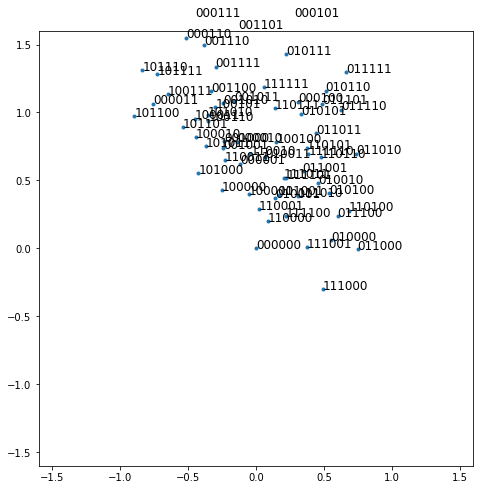

In [19]:
# constellation before training
[constellation,constellation_bits] = sess.run([enc_seed,xSeed])
plt.figure(figsize=(8,8))
plt.plot(constellation[:,0],constellation[:,1],'.')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0], constellation[ii,1], bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [20]:
bestLoss = 100000
bestAcc = 0
lastImprovement = 0
epoche = 0
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
batchSizeMultiples = 1
batchSize = batchSizeMultiples * trainingParam.batchSize

np_loss = []
np_ber  = []
np_gaussian_gmi  = []
np_sigmoid_gmi  = []

### Comment on the training procedure:
The training gets stuck early when a large batch size is chosen. For this reason we start with a low batch size, and iterativley increase it after temporary convergence. Training with a low batch size introduces a more stochastic gradient estimation, which helps to get out of the local minima.

In [21]:
print( 'START TRAINING ... ', flush=True )
while(True):
    epoche = epoche + 1

    sess.run(resetOps)
    
    # train AE with iteratively increasing batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(batchSize,chParam.M)}
        sess.run(d_sigmoid_loss, feed_dict=feedDict)

    # gather performance metrics with large batch size
    for batch in range(0,nBatches):
        feedDict = {X: cu.generateBitVectors(trainingParam.sampleSize,chParam.M)}
        sess.run(updateOps, feed_dict=feedDict)

    [outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)

    np_loss.append( outAvgLoss )
    np_ber.append( outAvgBer )
    np_gaussian_gmi.append( outAvgGaussianGmi )
    np_sigmoid_gmi.append( outAvgSigmoidGmi )
    
    if trainingParam.summaries:
        epocheSummaries = sess.run(epoche_summaries, feed_dict=feedDict)
        train_writer.add_summary(epocheSummaries,epoche)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    # convergence check and trainingState
    if epoche - lastImprovement > trainingParam.earlyStopping:

        saver.restore(sess=sess,save_path=checkpoint_path)
        bestLoss = 10000
        lastImprovement = epoche
        
        batchSizeMultiples = batchSizeMultiples + 4
        batchSize = batchSizeMultiples * trainingParam.batchSize        
        if batchSizeMultiples >= 17:
            break;

        print("batchSize: {}, batchSizeMultiples: {}".format(batchSize,batchSizeMultiples))

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {:04d} - avgLoss: {:.2f} - avgBer: {:.2e} - avgGaussianGmi: {:.2f} - avgSigmoidGmi: {:.2f}'.format(epoche,outAvgLoss,outAvgBer,outAvgGaussianGmi,outAvgSigmoidGmi),flush=True)

START TRAINING ... 
epoche: 0025 - avgLoss: 0.16 - avgBer: 8.82e-02 - avgGaussianGmi: 4.94 - avgSigmoidGmi: 4.60
epoche: 0050 - avgLoss: 0.14 - avgBer: 7.41e-02 - avgGaussianGmi: 5.04 - avgSigmoidGmi: 4.77
epoche: 0075 - avgLoss: 0.14 - avgBer: 6.94e-02 - avgGaussianGmi: 5.13 - avgSigmoidGmi: 4.82
epoche: 0100 - avgLoss: 0.12 - avgBer: 5.72e-02 - avgGaussianGmi: 5.20 - avgSigmoidGmi: 4.97
epoche: 0125 - avgLoss: 0.11 - avgBer: 5.15e-02 - avgGaussianGmi: 5.24 - avgSigmoidGmi: 5.04
epoche: 0150 - avgLoss: 0.11 - avgBer: 4.72e-02 - avgGaussianGmi: 5.28 - avgSigmoidGmi: 5.04
epoche: 0175 - avgLoss: 0.11 - avgBer: 4.82e-02 - avgGaussianGmi: 5.30 - avgSigmoidGmi: 5.03
epoche: 0200 - avgLoss: 0.11 - avgBer: 4.67e-02 - avgGaussianGmi: 5.28 - avgSigmoidGmi: 5.03
epoche: 0225 - avgLoss: 0.10 - avgBer: 4.28e-02 - avgGaussianGmi: 5.31 - avgSigmoidGmi: 5.11
epoche: 0250 - avgLoss: 0.10 - avgBer: 4.06e-02 - avgGaussianGmi: 5.30 - avgSigmoidGmi: 5.15


W0921 22:25:18.857707 139716625557312 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


batchSize: 320, batchSizeMultiples: 5
epoche: 0275 - avgLoss: 0.09 - avgBer: 3.61e-02 - avgGaussianGmi: 5.32 - avgSigmoidGmi: 5.24
epoche: 0300 - avgLoss: 0.08 - avgBer: 3.39e-02 - avgGaussianGmi: 5.35 - avgSigmoidGmi: 5.27
epoche: 0325 - avgLoss: 0.08 - avgBer: 3.17e-02 - avgGaussianGmi: 5.36 - avgSigmoidGmi: 5.32
epoche: 0350 - avgLoss: 0.08 - avgBer: 3.37e-02 - avgGaussianGmi: 5.34 - avgSigmoidGmi: 5.28
batchSize: 576, batchSizeMultiples: 9
epoche: 0375 - avgLoss: 0.08 - avgBer: 3.12e-02 - avgGaussianGmi: 5.36 - avgSigmoidGmi: 5.31
epoche: 0400 - avgLoss: 0.08 - avgBer: 3.12e-02 - avgGaussianGmi: 5.36 - avgSigmoidGmi: 5.31
batchSize: 832, batchSizeMultiples: 13
epoche: 0425 - avgLoss: 0.08 - avgBer: 3.17e-02 - avgGaussianGmi: 5.35 - avgSigmoidGmi: 5.32
epoche: 0450 - avgLoss: 0.08 - avgBer: 3.13e-02 - avgGaussianGmi: 5.36 - avgSigmoidGmi: 5.31
epoche: 0475 - avgLoss: 0.08 - avgBer: 3.05e-02 - avgGaussianGmi: 5.36 - avgSigmoidGmi: 5.33
epoche: 0500 - avgLoss: 0.08 - avgBer: 3.09e-02 

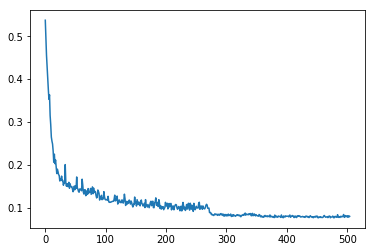

In [22]:
saver.restore(sess=sess,save_path=checkpoint_path)
np_loss = np.array( np_loss )
np_ber  = np.array( np_ber )
np_gaussian_gmi  = np.array( np_gaussian_gmi )
np_sigmoid_gmi  = np.array( np_sigmoid_gmi )
plt.plot( np_loss )

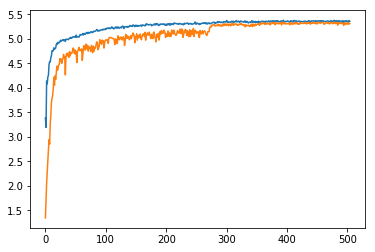

In [23]:
plt.plot( np_gaussian_gmi )
plt.plot( np_sigmoid_gmi )

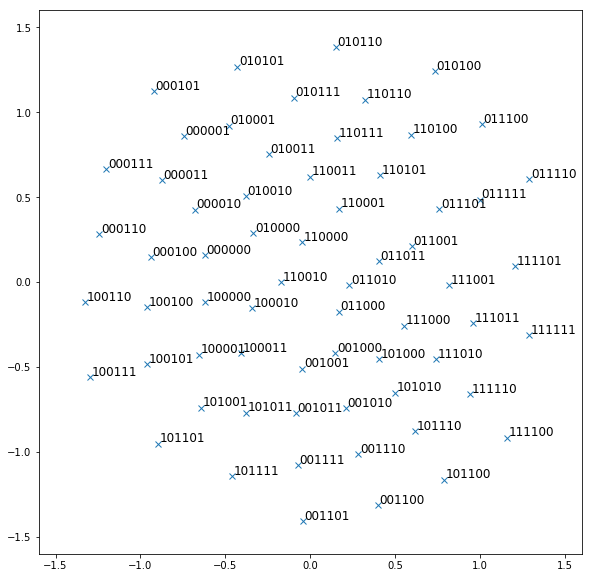

In [40]:
# constellation after training
[constellation,constellation_bits] = sess.run([enc_seed,xSeed])
plt.figure(figsize=(10,10))
plt.plot(constellation[:,0],constellation[:,1],'x')

for ii in range(constellation.shape[0]):
    bit_string = ''.join( [ str(int(x)) for x in allCombinations[ii,:].tolist()] )
    plt.text(constellation[ii,0]+0.01, constellation[ii,1]+0.01, bit_string, fontsize=12)
plt.axis('square');
lim_ = 1.6
plt.xlim(-lim_,lim_);
plt.ylim(-lim_,lim_);

In [41]:
sess.run(resetOps)
for batch in range(0,100):
    feedDict = {X: cu.generateBitVectors(1000,chParam.M)}
    sess.run(updateOps, feed_dict=feedDict)
[outAvgLoss, outAvgBer, outAvgGaussianGmi, outAvgSigmoidGmi] = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)

finalMetrics = { 'GaussianGMI': outAvgGaussianGmi, 'SigmoidGMI': outAvgSigmoidGmi, 'BER': outAvgBer, 'xentropy': outAvgLoss }
print( 'finalMetrics:', finalMetrics )

finalMetrics: {'GaussianGMI': 5.357472, 'SigmoidGMI': 5.325186, 'BER': 0.030881666, 'xentropy': 0.077957615}
